In [5]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
import matplotlib.animation
from matplotlib.animation import FuncAnimation, PillowWriter
import networkx as nx
import scipy.linalg as la
import scipy

# Set up plotting parameters
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2

---

# QUBO and Ising Models for Quantum Annealing

Number of vertices: 5
Number of edges: 6
Maximum cut size: 5
Optimal partition: [1, 0, 0, 1, 0]


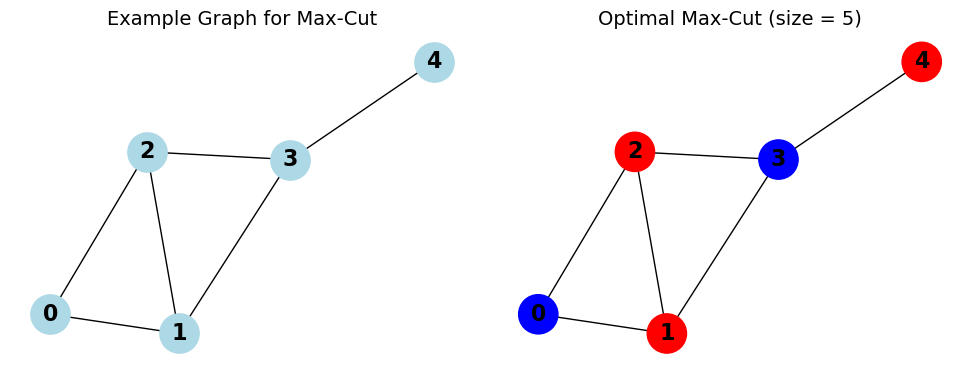

In [6]:
# Example 1: Max-Cut Problem
# partition vertices to maximize edges between partitions

class MaxCutProblem:
    """Max-Cut problem formulation"""
    
    def __init__(self, graph):
        self.graph = graph
        self.n_vertices = len(graph.nodes())
        
    def qubo_matrix(self):
        """Generate QUBO matrix for max-cut"""
        n = self.n_vertices
        Q = np.zeros((n, n))
        
        # For max-cut: maximize sum of (x_i - x_j)^2 over edges
        # Equivalent to minimizing: -sum of (x_i + x_j - 2*x_i*x_j)
        for i, j in self.graph.edges():
            Q[i, i] += -1
            Q[j, j] += -1
            if i < j:
                Q[i, j] += 2
            else:
                Q[j, i] += 2
        
        return Q
    
    def ising_parameters(self):
        """Convert to Ising formulation"""
        J = {}  # Coupling matrix
        h = np.zeros(self.n_vertices)  # Local fields
        
        # For max-cut in Ising: minimize sum of s_i * s_j over edges
        for i, j in self.graph.edges():
            J[(i, j)] = 1.0  # Antiferromagnetic for max-cut
        
        return J, h
    
    def evaluate_qubo(self, x):
        """Evaluate QUBO objective for binary vector x"""
        Q = self.qubo_matrix()
        return x @ Q @ x
    
    def evaluate_ising(self, s):
        """Evaluate Ising energy for spin configuration s"""
        J, h = self.ising_parameters()
        energy = 0
        for (i, j), coupling in J.items():
            energy += coupling * s[i] * s[j]
        for i in range(len(s)):
            energy += h[i] * s[i]
        return energy
    
    def cut_size(self, partition):
        """Calculate the actual cut size"""
        cut = 0
        for i, j in self.graph.edges():
            if partition[i] != partition[j]:
                cut += 1
        return cut

# Create a small example graph
G = nx.Graph()
G.add_edges_from([(0, 1), (0, 2), (1, 2), (1, 3), (2, 3), (3, 4)])

# Visualize the graph
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
pos = nx.spring_layout(G, seed=42)
nx.draw(G, pos, with_labels=True, node_color='lightblue', 
        node_size=800, font_size=16, font_weight='bold')
plt.title('Example Graph for Max-Cut', fontsize=14)

# Try all possible partitions and find optimal
max_cut = MaxCutProblem(G)
n = max_cut.n_vertices
best_cut = 0
best_partition = None

all_cuts = []
for i in range(2**n):
    # Binary representation
    partition = [(i >> j) & 1 for j in range(n)]
    cut = max_cut.cut_size(partition)
    all_cuts.append(cut)
    if cut > best_cut:
        best_cut = cut
        best_partition = partition

print(f"Number of vertices: {n}")
print(f"Number of edges: {len(G.edges())}")
print(f"Maximum cut size: {best_cut}")
print(f"Optimal partition: {best_partition}")

# Visualize best partition
plt.subplot(1, 2, 2)
node_colors = ['red' if best_partition[node] == 0 else 'blue' for node in G.nodes()]
nx.draw(G, pos, with_labels=True, node_color=node_colors, 
        node_size=800, font_size=16, font_weight='bold')
plt.title(f'Optimal Max-Cut (size = {best_cut})', fontsize=14)

plt.tight_layout()
plt.savefig('figures/maxcut_example.png', dpi=300, bbox_inches='tight')
plt.show()

## Adiabatic GIF

In [7]:
# Quantum box parameters
L0 = 1.0         # Initial box length
L1 = 2.0         # Final box length
N = 1000         # Number of spatial points
x = np.linspace(0, L1, N)
n = 1            # Ground state

def psi_box(x, L, n):
    """Ground state wavefunction in box of length L."""
    psi = np.sqrt(2/L) * np.sin(n * np.pi * x / L)
    psi[x > L] = 0
    return psi

In [8]:
def abrupt_schedule(t, T):
    """Abrupt change: wall jumps at t=0.5*T."""
    return L0 if t < 0.5*T else L1

def adiabatic_schedule(t, T):
    """Smooth linear change."""
    return L0 + (L1 - L0) * t / T

In [9]:
def animate_wavefunction(schedule, T, nframes, title, filename):
    fig, ax = plt.subplots(figsize=(6, 4))
    line, = ax.plot([], [], 'b-', lw=2)
    ax.set_xlim(0, L1)
    ax.set_ylim(0, 2)
    ax.set_xlabel('x')
    ax.set_ylabel(r'$|\psi(x)|^2$')
    ax.set_title(title)

    def init():
        line.set_data([], [])
        return line,

    def update(frame):
        t = frame / nframes * T
        L = schedule(t, T)
        psi = psi_box(x, L, n)
        prob = np.abs(psi)**2
        line.set_data(x, prob)
        ax.set_xlim(0, L1)
        ax.set_ylim(0, 2)
        ax.axvline(L, color='k', ls='--', alpha=0.5)
        return line,

    anim = FuncAnimation(fig, update, frames=nframes, init_func=init, blit=True)
    anim.save(filename, writer=PillowWriter(fps=20))
    plt.close()


In [10]:
def make_adiabatic_potential_animation(potential, L=200):

    x = np.arange(L)
    
    # initial Ham and ground state
    ham_initial, _ = _make_hamiltonian(L, potential, 0)
    psi_0 = la.eigh(ham_initial.todense())[1][:, 0]
    psi_0_qt = Qobj(psi_0)  # Convert to QuTiP object
    
    # Time evolution parameters
    n_steps = 300
    dt = 10  # time step between frames
    save_every = 3  # save every 3rd frame
    
    # TD Ham as QOBJ
    #sesolve callback function
    def H_t(t, args):
        n = int(t / dt)
        if n >= n_steps:
            n = n_steps - 1
        ham, _ = _make_hamiltonian(L, potential, n)
        return Qobj(ham.todense())
    
    # Time points where we want to save the state
    times = np.arange(0, n_steps * dt, save_every * dt)
    
    # Evolve using sesolve
    result = sesolve(H_t, psi_0_qt, times, [])
    
    # Extract wavefunctions and potentials at saved times
    psis = [state.full().flatten() for state in result.states]
    pots = []
    for i in range(len(times)):
        n = int(times[i] / dt)
        _, pot = _make_hamiltonian(L, potential, n)
        pots.append(pot)
    
    fig, ax = plt.subplots(figsize=(8,3))
    plt.close()  # this prevents the output of an empty frame
    l1, = ax.plot(x, abs(psis[0])**2, label="$|\psi(x)|^2$")
    l2, = ax.plot(x, pots[0], label="$V(x)$")
    ax.set_xlabel("$x$")
    ax.legend(loc="upper right")
    ax.set_ylim(0, 0.05)

    def animate(i):
        l1.set_data(x, abs(psis[i])**2)
        l2.set_data(x, pots[i])
        return (l1, l2)

    anim = matplotlib.animation.FuncAnimation(fig, animate, frames=len(psis), interval=50)
    
    return anim

def _make_hamiltonian(L=100, pot_func=None, time=0, t=1):
    
    ham = np.zeros(shape=(L, L), dtype=complex)
    pot = np.array([pot_func(i, time) for i in range(L)], dtype=float)
    np.fill_diagonal(ham, 2 * t + pot)
    
    offdiag = np.zeros(shape=(L-1,), dtype=complex)
    offdiag[:] = -t
    np.fill_diagonal(ham[1:, :-1], offdiag)
    np.fill_diagonal(ham[:-1, 1:], offdiag)
    
    # finally, periodic boundary conditions
    ham[0, -1] = -t
    ham[-1, 0] = -t
    
    return scipy.sparse.csr_matrix(ham), pot

<>:40: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:40: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/tmp/ipykernel_5236/538185852.py:40: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  l1, = ax.plot(x, abs(psis[0])**2, label="$|\psi(x)|^2$")


In [11]:
L = 200
def pot_abrupt(i, t):
    if t < 50:
        width = L/1.7
    else:
        width = L
    return np.tanh((i - width + 30) / 5) + 1 - np.tanh((i - 30) / 5) + 1

anim = make_adiabatic_potential_animation(potential=pot_abrupt)
anim.save('figures/adiabatic_potential_animation.gif')
print("Animation saved to adiabatic_potential_animation.gif")

/home/niall/miniconda3/envs/quantum-project/lib/python3.14/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved to adiabatic_potential_animation.gif


In [12]:
L = 200
def pot_slow(i, t):
    width = L/1.7 + t/600 * (L - L/1.7)

    return np.tanh((i - width + 30) / 5) + 1 - np.tanh((i - 30) / 5) + 1

anim = make_adiabatic_potential_animation(potential=pot_slow)
anim.save('figures/slow_adiabatic_potential_animation.gif')
print("Animation saved to slow_adiabatic_potential_animation.gif")

/home/niall/miniconda3/envs/quantum-project/lib/python3.14/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(
MovieWriter ffmpeg unavailable; using Pillow instead.
MovieWriter ffmpeg unavailable; using Pillow instead.


Animation saved to slow_adiabatic_potential_animation.gif


---
# Spin-1/2 in Rotating Magnetic Field: Berry Phase Demonstration

In [13]:
# Define the spin-1/2 system in a rotating magnetic field
class SpinHalfBerryPhase:
    def __init__(self, B0=1.0, theta=np.pi/3, gamma=1.0):
        """
        Initialize the spin-1/2 system in a rotating magnetic field.
        """
        self.B0 = B0
        self.theta = theta
        self.gamma = gamma
        
        # Pauli matrices
        self.sx = sigmax()
        self.sy = sigmay()
        self.sz = sigmaz()
        
        # Identity
        self.I = qeye(2)
        
    def hamiltonian(self, t, omega):
        """
        Time-dependent Hamiltonian for rotating magnetic field.
        """
        Bx = np.sin(self.theta) * np.cos(omega * t)
        By = np.sin(self.theta) * np.sin(omega * t)
        Bz = np.cos(self.theta)
        
        H = -self.gamma * self.B0 * (Bx * self.sx + By * self.sy + Bz * self.sz)
        return H
    
    def initial_state(self):
        """
        Initial state aligned with B(t=0) = B0(sin(theta), 0, cos(theta))
        This is the instantaneous ground state at t=0.
        """
        # Eigenstate of H(t=0)
        H0 = self.hamiltonian(0, 0)
        _, eigvecs = H0.eigenstates()
        # Return ground state (lowest energy)
        return eigvecs[0]
    
    def evolve_system(self, omega, n_periods=1, n_steps=200):
        """
        Evolve the spin system for n_periods of rotation.
        """
        T = 2 * np.pi / omega  # Period of one rotation
        t_final = n_periods * T
        times = np.linspace(0, t_final, n_periods * n_steps)
        
        # Initial state
        psi0 = self.initial_state()
        
        # Time-dependent Hamiltonian as a list [H0, [H1, f1(t)], ...]
        # H(t) = -gamma*B0*(sin(theta)*(cos(omega*t)*sx + sin(omega*t)*sy) + cos(theta)*sz)
        H0 = -self.gamma * self.B0 * np.cos(self.theta) * self.sz
        H_cos = -self.gamma * self.B0 * np.sin(self.theta) * self.sx
        H_sin = -self.gamma * self.B0 * np.sin(self.theta) * self.sy
        
        H = [H0, [H_cos, lambda t, args: np.cos(omega * t)], 
                 [H_sin, lambda t, args: np.sin(omega * t)]]
        
        # Solve Schrodinger equation
        result = sesolve(H, psi0, times, [])
        
        return times, result.states

In [14]:
# Helper functions for visualization
def compute_expectation_values(states, sx, sy, sz):
    """
    Compute expectation values of spin components.
    """
    sx_exp = np.array([expect(sx, state) for state in states])
    sy_exp = np.array([expect(sy, state) for state in states])
    sz_exp = np.array([expect(sz, state) for state in states])
    
    return sx_exp, sy_exp, sz_exp

def compute_magnetic_field_direction(times, theta, omega):
    """
    Compute the direction of the magnetic field as a function of time.
    """
    Bx = np.sin(theta) * np.cos(omega * times)
    By = np.sin(theta) * np.sin(omega * times)
    Bz = np.cos(theta) * np.ones_like(times)
    
    return Bx, By, Bz

def compute_berry_phase_from_evolution(states, psi0):
    """
    Compute the Berry phase from the final state after one complete rotation.
    
    The Berry phase is the argument of <psi_final|psi_0> after removing the 
    dynamical phase (which is zero for this case since eigenvalues don't change).
    """
    psi_final = states[-1]
    
    # Compute overlap
    overlap = psi_final.overlap(psi0)
    
    # Extract phase
    phase = np.angle(overlap)
    
    return phase

In [15]:
# Create the spin system and compare adiabatic vs non-adiabatic evolution
B0 = 1.0
theta = np.pi / 3  # 60 degrees
gamma = 1.0

spin_system = SpinHalfBerryPhase(B0=B0, theta=theta, gamma=gamma)

# Define two rotation frequencies
# Adiabatic: omega << gamma*B0
omega_adiabatic = 0.05 * gamma * B0  

# Non-adiabatic: omega ~ gamma*B0
omega_nonadiabatic = 1.0 * gamma * B0

# Evolve both systems for one complete rotation
print("\nEvolving adiabatic system...")
times_adiabatic, states_adiabatic = spin_system.evolve_system(
    omega_adiabatic, n_periods=1, n_steps=200
)

print("Evolving non-adiabatic system...")
times_nonadiabatic, states_nonadiabatic = spin_system.evolve_system(
    omega_nonadiabatic, n_periods=1, n_steps=200
)

print("Evolution complete!")


Evolving adiabatic system...
Evolving non-adiabatic system...
Evolution complete!


/home/niall/miniconda3/envs/quantum-project/lib/python3.14/site-packages/qutip/solver/solver_base.py:598: FutureWarning: e_ops will be keyword only from qutip 5.3 for all solver
  warnings.warn(


In [16]:
# Compute expectation values and magnetic field directions for Berry phase animation
sx_adia, sy_adia, sz_adia = compute_expectation_values(
    states_adiabatic, spin_system.sx, spin_system.sy, spin_system.sz
)

sx_nadia, sy_nadia, sz_nadia = compute_expectation_values(
    states_nonadiabatic, spin_system.sx, spin_system.sy, spin_system.sz
)

Bx_adia, By_adia, Bz_adia = compute_magnetic_field_direction(
    times_adiabatic, theta, omega_adiabatic
)

Bx_nadia, By_nadia, Bz_nadia = compute_magnetic_field_direction(
    times_nonadiabatic, theta, omega_nonadiabatic
)

print("Berry phase data computed!")

Berry phase data computed!


In [17]:
# Create a combined vertical comparison animation (or save frames as PNGs)
def create_comparison_animation(times_adia, sx_adia, sy_adia, sz_adia, Bx_adia, By_adia, Bz_adia, omega_adia,
                                times_nadia, sx_nadia, sy_nadia, sz_nadia, Bx_nadia, By_nadia, Bz_nadia, omega_nadia,
                                filename='figures/berry_phase_comparison.gif', n_frames=100, frames_dir='figures/frames_berry_phase'):
    """
    Create vertical comparison of adiabatic and non-adiabatic evolution (one above the other).
    """

    fig = plt.figure(figsize=(8, 12))
    
    # Create subplots stacked vertically (2 rows, 1 column)
    ax1 = fig.add_subplot(211, projection='3d')
    ax2 = fig.add_subplot(212, projection='3d')
    
    axes = [ax1, ax2]
    data_sets = [
        (times_adia, sx_adia, sy_adia, sz_adia, Bx_adia, By_adia, Bz_adia),
        (times_nadia, sx_nadia, sy_nadia, sz_nadia, Bx_nadia, By_nadia, Bz_nadia)
    ]
    
    # Unit sphere coordinates
    u = np.linspace(0, 2 * np.pi, 30)
    v = np.linspace(0, np.pi, 30)
    x_sphere = 0.98 * np.outer(np.cos(u), np.sin(v))
    y_sphere = 0.98 * np.outer(np.sin(u), np.sin(v))
    z_sphere = 0.98 * np.outer(np.ones(np.size(u)), np.cos(v))

    # Set up both 3D plots
    for ax in axes:
        ax.set_xlim([-1.2, 1.2])
        ax.set_ylim([-1.2, 1.2])
        ax.set_zlim([-1.2, 1.2])
        ax.set_xlabel('X', fontsize=11, fontweight='bold')
        ax.set_ylabel('Y', fontsize=11, fontweight='bold')
        ax.set_zlabel('Z', fontsize=11, fontweight='bold')
        ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.08, color='lightgray')
        ax.view_init(elev=20, azim=45)
    
    # Sample frames
    frame_indices_adia = np.linspace(0, len(times_adia)-1, n_frames, dtype=int)
    frame_indices_nadia = np.linspace(0, len(times_nadia)-1, n_frames, dtype=int)
    
    def update(frame_num):
        idx_adia = frame_indices_adia[frame_num]
        idx_nadia = frame_indices_nadia[frame_num]
        indices = [idx_adia, idx_nadia]
        
        for i, (ax, (times, sx, sy, sz, Bx, By, Bz)) in enumerate(zip(axes, data_sets)):
            ax.clear()

            idx = indices[i]

            # Redraw sphere
            ax.plot_surface(x_sphere, y_sphere, z_sphere, alpha=0.08, color='lightgray')

            # Plot trajectory
            ax.plot(sx[:idx+1], sy[:idx+1], sz[:idx+1], 'b-', linewidth=2.5, alpha=0.7, label='Spin path')

            # Current spin vector
            ax.quiver(0, 0, 0, sx[idx], sy[idx], sz[idx], 
                     color='blue', arrow_length_ratio=0.2, linewidth=4, label='Spin')

            # Magnetic field vector
            ax.quiver(0, 0, 0, Bx[idx], By[idx], Bz[idx], 
                     color='red', arrow_length_ratio=0.2, linewidth=3, alpha=0.8, label='B field')

            # Initial position marker
            ax.scatter([sx[0]], [sy[0]], [sz[0]], color='green', s=100, marker='o', 
                      alpha=0.8, label='Start')

            # Current position marker
            ax.scatter([sx[idx]], [sy[idx]], [sz[idx]], color='blue', s=80, marker='o')

            ax.set_xlim([-1.2, 1.2])
            ax.set_ylim([-1.2, 1.2])
            ax.set_zlim([-1.2, 1.2])
            ax.set_xlabel('X', fontsize=11, fontweight='bold')
            ax.set_ylabel('Y', fontsize=11, fontweight='bold')
            ax.set_zlabel('Z', fontsize=11, fontweight='bold')

            # Only show legend on the first subplot (index 0)
            if i == 0:
                ax.legend(loc='upper left', fontsize=9)

            ax.view_init(elev=20, azim=45)

            # Add time info
            ax.text2D(0.02, 0.02, f't = {times[idx]:.2f}', transform=ax.transAxes, 
                     fontsize=10, bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    # Otherwise create animation GIF as before
    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)

    # Save animation
    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    print(f"Comparison animation saved to {filename}")

    plt.close()

    return anim


---
# Landau-Zener Diabatic Transition Animation

In [18]:
# Define the Landau-Zener system and evolve it
class LandauZenerSystem:
    def __init__(self, Delta=1.0):
        """
        Initialize the Landau-Zener system.
        Delta: coupling strength (avoided crossing gap is Delta)
        """
        self.Delta = Delta
        self.sx = sigmax()
        self.sz = sigmaz()

    def hamiltonian(self, t, args):
        """
        Time-dependent Hamiltonian for the Landau-Zener problem.
        H(t) = eps(t)/2 * sigma_z + Delta/2 * sigma_x
        """
        # args should contain the sweep rate 'v'
        v = args['v']
        eps_t = v * t
        
        H = 0.5 * eps_t * self.sz + 0.5 * self.Delta * self.sx
        return H

    def solve(self, T, n_steps=500):
        """
        Solve the Schrodinger equation for a given total sweep time T.
        The time will range from -T/2 to T/2.
        """
        v = 20 / T  # Sweep rate to go from -10 to 10 in time T
        
        times = np.linspace(-T/2, T/2, n_steps)
        
        # Initial state is the ground state at t = -T/2
        H_initial = self.hamiltonian(-T/2, {'v': v})
        _, psi0 = H_initial.groundstate()
        
        # Solve the system
        result = sesolve(self.hamiltonian, psi0, times, args={'v': v})
        
        # Calculate populations and instantaneous energies
        pop_g = []
        pop_e = []
        E0_list = []
        E1_list = []
        eps_list = []

        for i, t in enumerate(times):
            H_t = self.hamiltonian(t, {'v': v})
            evals, ekets = H_t.eigenstates()
            E0, E1 = evals
            psi_g, psi_e = ekets
            
            # Population of instantaneous ground and excited states
            pop_g.append(np.abs(result.states[i].overlap(psi_g))**2)
            pop_e.append(np.abs(result.states[i].overlap(psi_e))**2)
            
            E0_list.append(E0)
            E1_list.append(E1)
            eps_list.append(v * t)
            
        return (times, result.states, 
                np.array(pop_g), np.array(pop_e), 
                np.array(eps_list), np.array(E0_list), np.array(E1_list))

# --- Generate Data ---

# Initialize the system
lz_problem = LandauZenerSystem(Delta=2.0)

# Adiabatic case (slow sweep)
T_adiabatic = 20.0  # Time from -10 to 10
(times_adia, states_adia, pop_g_adia, pop_e_adia, 
 eps_adia, E0_adia, E1_adia) = lz_problem.solve(T_adiabatic)

# Diabatic case (fast sweep)
T_diabatic = 2.0  # Time from -1 to 1
(times_diab, states_diab, pop_g_diab, pop_e_diab, 
 eps_diab, E0_diab, E1_diab) = lz_problem.solve(T_diabatic)

print("Landau-Zener data generated for both adiabatic and diabatic cases.")


Landau-Zener data generated for both adiabatic and diabatic cases.


In [19]:
# Redefine Landau-Zener comparison animation to exclude Bloch-sphere visuals
# This cell overrides the existing create_lz_comparison_animation and writes a GIF without Bloch spheres.

def create_lz_comparison_animation_no_bloch(times_adia, states_adia, pop_g_adia, pop_e_adia, eps_adia, E0_adia, E1_adia,
                                            times_diab, states_diab, pop_g_diab, pop_e_diab, eps_diab, E0_diab, E1_diab,
                                            Delta, T_adia, T_diab, filename='figures/landau_zener_comparison.gif', n_frames=100,
                                            frames_dir='figures/frames_lz_no_bloch'):
    """
    Create a comparison animation for Landau-Zener dynamics WITHOUT any Bloch-sphere panels.
    Left column shows adiabatic evolution (energies + populations), right column shows diabatic evolution.
    """
    fig, axes = plt.subplots(2, 2, figsize=(12, 8))
    fig.suptitle('Landau-Zener Dynamics: Avoided Crossing at t=0', fontsize=14, fontweight='bold')
    axE_adia, axE_diab = axes[0]
    axP_adia, axP_diab = axes[1]

    # Preplot static curves (energies over full time) with light alpha
    axE_adia.plot(times_adia, E0_adia, 'b-', alpha=0.3, label='$E_0$')
    axE_adia.plot(times_adia, E1_adia, 'r-', alpha=0.3, label='$E_1$')
    axE_adia.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
    axE_adia.set_xlabel('t'); axE_adia.set_ylabel('Energy')
    axE_adia.set_title('Adiabatic (Slow)', fontsize=12, fontweight='bold')

    axE_diab.plot(times_diab, E0_diab, 'b-', alpha=0.3, label='$E_0$')
    axE_diab.plot(times_diab, E1_diab, 'r-', alpha=0.3, label='$E_1$')
    axE_diab.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)
    axE_diab.set_xlabel('t'); axE_diab.set_ylabel('Energy')
    axE_diab.set_title('Diabatic (Fast)', fontsize=12, fontweight='bold')

    # Population axes: set fixed y-limits so populations don't rescale during animation
    axP_adia.set_xlabel('t'); axP_adia.set_ylabel('Population')
    axP_adia.set_ylim(-0.05, 1.05)
    axP_adia.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)

    axP_diab.set_xlabel('t'); axP_diab.set_ylabel('Population')
    axP_diab.set_ylim(-0.05, 1.05)
    axP_diab.axvline(x=0, color='gray', linestyle='--', alpha=0.5, linewidth=1.5)

    # Determine reasonable fixed energy limits (with small padding)
    emin_adia = min(E0_adia.min(), E1_adia.min())
    emax_adia = max(E0_adia.max(), E1_adia.max())
    pad_adia = 0.05 * (emax_adia - emin_adia if emax_adia>emin_adia else 1.0)
    axE_adia.set_xlim([times_adia[0], times_adia[-1]])
    axE_adia.set_ylim([emin_adia - pad_adia, emax_adia + pad_adia])

    emin_diab = min(E0_diab.min(), E1_diab.min())
    emax_diab = max(E0_diab.max(), E1_diab.max())
    pad_diab = 0.05 * (emax_diab - emin_diab if emax_diab>emin_diab else 1.0)
    axE_diab.set_xlim([times_diab[0], times_diab[-1]])
    axE_diab.set_ylim([emin_diab - pad_diab, emax_diab + pad_diab])

    # Prepare artists for updating
    line_E0_adia, = axE_adia.plot([], [], 'b-', linewidth=2)
    line_E1_adia, = axE_adia.plot([], [], 'r-', linewidth=2)
    dot_E_adia, = axE_adia.plot([], [], marker='o', color='k')

    line_E0_diab, = axE_diab.plot([], [], 'b-',linewidth=2)
    line_E1_diab, = axE_diab.plot([], [], 'r-',linewidth=2)
    dot_E_diab, = axE_diab.plot([], [], marker='o', color='k')

    line_pg_adia, = axP_adia.plot([], [], 'b-',linewidth=2, label='ground')
    line_pe_adia, = axP_adia.plot([], [], 'r-',linewidth=2, label='excited')
    dot_p_adia, = axP_adia.plot([], [], marker='o', color='k')

    line_pg_diab, = axP_diab.plot([], [], 'b-',linewidth=2, label='ground')
    line_pe_diab, = axP_diab.plot([], [], 'r-',linewidth=2, label='excited')
    dot_p_diab, = axP_diab.plot([], [], marker='o', color='k')

    axP_adia.legend(loc='upper right')
    axP_diab.legend(loc='upper right')

    # frame indices
    idxs_adia = np.linspace(0, len(times_adia)-1, n_frames, dtype=int)
    idxs_diab = np.linspace(0, len(times_diab)-1, n_frames, dtype=int)

    def update(frame):
        ia = idxs_adia[frame]
        idb = idxs_diab[frame]

        # Get current state (ground or excited) based on population
        is_ground_adia = pop_g_adia[ia] > 0.5
        is_ground_diab = pop_g_diab[idb] > 0.5
        
        E_adia_current = E0_adia[ia] if is_ground_adia else E1_adia[ia]
        E_diab_current = E0_diab[idb] if is_ground_diab else E1_diab[idb]

        # energies up to current
        line_E0_adia.set_data(times_adia[:ia+1] if is_ground_adia else [], E0_adia[:ia+1] if is_ground_adia else [])
        line_E1_adia.set_data(times_adia[:ia+1] if not is_ground_adia else [], E1_adia[:ia+1] if not is_ground_adia else [])
        dot_E_adia.set_data([times_adia[ia]], [E_adia_current])

        line_E0_diab.set_data(times_diab[:idb+1] if is_ground_diab else [], E0_diab[:idb+1] if is_ground_diab else [])
        line_E1_diab.set_data(times_diab[:idb+1] if not is_ground_diab else [], E1_diab[:idb+1] if not is_ground_diab else [])
        dot_E_diab.set_data([times_diab[idb]], [E_diab_current])

        # populations
        line_pg_adia.set_data(times_adia[:ia+1], pop_g_adia[:ia+1])
        line_pe_adia.set_data(times_adia[:ia+1], pop_e_adia[:ia+1])
        dot_p_adia.set_data([times_adia[ia]], [pop_g_adia[ia]])

        line_pg_diab.set_data(times_diab[:idb+1], pop_g_diab[:idb+1])
        line_pe_diab.set_data(times_diab[:idb+1], pop_e_diab[:idb+1])
        dot_p_diab.set_data([times_diab[idb]], [pop_g_diab[idb]])

        # Keep axes fixed (no autoscale)
        axE_adia.set_xlim([times_adia[0], times_adia[-1]])
        axE_adia.set_ylim([emin_adia - pad_adia, emax_adia + pad_adia])
        axE_diab.set_xlim([times_diab[0], times_diab[-1]])
        axE_diab.set_ylim([emin_diab - pad_diab, emax_diab + pad_diab])
        axP_adia.set_xlim([times_adia[0], times_adia[-1]])
        axP_adia.set_ylim([-0.05, 1.05])
        axP_diab.set_xlim([times_diab[0], times_diab[-1]])
        axP_diab.set_ylim([-0.05, 1.05])

        return (line_E0_adia, line_E1_adia, dot_E_adia,
                line_E0_diab, line_E1_diab, dot_E_diab,
                line_pg_adia, line_pe_adia, dot_p_adia,
                line_pg_diab, line_pe_diab, dot_p_diab)

    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)

    # Save
    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f'Wrote LZ comparison GIF without Bloch spheres to {filename}')
    return anim

# If the notebook had previously created anim_lz_comparison, overwrite it by calling this new function using
# the variables already present in the notebook (if they've been executed). This will regenerate the GIF.
# Side-by-side comparison frames (no Bloch spheres)
create_lz_comparison_animation_no_bloch(
    times_adia, states_adia, pop_g_adia, pop_e_adia, eps_adia, E0_adia, E1_adia,
    times_diab, states_diab, pop_g_diab, pop_e_diab, eps_diab, E0_diab, E1_diab,
    lz_problem.Delta, T_adiabatic, T_diabatic,
    filename='figures/landau_zener_comparison.gif', n_frames=120, frames_dir='figures/frames_lz_no_bloch'
)


Wrote LZ comparison GIF without Bloch spheres to figures/landau_zener_comparison.gif


---

# Born-Oppenheimer Approximation: Fast Electrons vs Slow Nuclei

In [20]:
# Born-Oppenheimer model: 1D simplified diatomic molecule
class BornOppenheimerModel:
    """
    1D diatomic molecule with nuclei at \pm R/2
    e in double well potential with wf adjsuting to seperation
    """
    
    def __init__(self, m_electron=1.0, m_nucleus=1836.0):
        self.m_e = m_electron
        self.m_n = m_nucleus
        
    def electronic_potential(self, x, R):
        """
        Electronic potential energy for electron at position x
        with nuclei at ±R/2
        
        Simple double-well: V(x) = -V0 * [exp(-a*(x+R/2)^2) + exp(-a*(x-R/2)^2)]
        """
        V0 = 5.0
        a = 2.0
        V = -V0 * (np.exp(-a * (x + R/2)**2) + np.exp(-a * (x - R/2)**2))
        return V
    
    def solve_electronic_structure(self, R, N=500, x_range=10.0):
        """
        Solve for electronic ground state at fixed nuclear separation R
        """
        # Position grid
        x = np.linspace(-x_range, x_range, N)
        dx = x[1] - x[0]
        
        # Potential
        V = self.electronic_potential(x, R)
        
        # Kinetic energy (finite difference)
        T = np.zeros((N, N))
        for i in range(N):
            T[i, i] = 2.0
            if i > 0:
                T[i, i-1] = -1.0
            if i < N-1:
                T[i, i+1] = -1.0
        T = T / (2 * self.m_e * dx**2)
        
        # Hamiltonian
        H = T + np.diag(V)
        
        # Solve
        eigenvalues, eigenvectors = np.linalg.eigh(H)
        
        # Ground state
        psi = eigenvectors[:, 0]
        E = eigenvalues[0]
        
        # Normalize
        psi = psi / np.sqrt(np.sum(psi**2) * dx)
        
        return x, psi, E, V
    
    def potential_energy_curve(self, R_values):
        """
        Compute Born-Oppenheimer potential energy curve E(R)
        """
        energies = []
        for R in R_values:
            _, _, E, _ = self.solve_electronic_structure(R)
            # Add nuclear repulsion (Coulomb)
            E_nuc = 1.0 / (R + 0.1)  # Add small constant to avoid singularity
            energies.append(E + E_nuc)
        return np.array(energies)


<>:4: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:4: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/tmp/ipykernel_5236/953719692.py:4: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  1D diatomic molecule with nuclei at \pm R/2


In [21]:
# Create the Born-Oppenheimer animation
def create_born_oppenheimer_animation(filename='figures/born_oppenheimer.gif', 
                                     n_frames=120,  
                                     frames_dir='figures/frames_born_oppenheimer'):
    """
    Animate Born-Oppenheimer approximation:
    Shows electronic wavefunction adjusting adiabatically to slowly moving nuclei
    """
    import os
    
    # Initialize model
    bo_model = BornOppenheimerModel()
    
    # Nuclear motion: slow oscillation around equilibrium
    R_eq = 3.0  # Equilibrium separation
    R_amp = 1.5  # Oscillation amplitude
    omega_n = 0.5  # Nuclear oscillation frequency (slow)
    
    # Time array
    T_total = 4 * np.pi / omega_n  # Two complete oscillations
    times = np.linspace(0, T_total, n_frames)
    
    # Nuclear trajectory
    R_trajectory = R_eq + R_amp * np.cos(omega_n * times)
    
    # Create figure with single plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Setup plot (Electronic wavefunction)
    line_psi, = ax.plot([], [], 'b-', linewidth=2.5, label='$|\psi_{elec}|^2$')
    line_V, = ax.plot([], [], 'r--', linewidth=2, alpha=0.6, label='V(x)')
    nuclei_markers, = ax.plot([], [], 'ko', markersize=18, label='Nuclei', markeredgewidth=2, markerfacecolor='red')
    ax.set_xlabel('Electronic Position x', fontsize=14)
    ax.set_ylabel('Probability Density / Potential', fontsize=14)
    ax.legend(loc='upper right', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-5, 3])
    
    # Add time annotation
    time_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=12,
                       verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.7))
    
    plt.tight_layout()
    
    def update(frame):
        # Current time and nuclear separation
        t = times[frame]
        R = R_trajectory[frame]
        
        # Solve electronic structure at current R
        x, psi, E, V = bo_model.solve_electronic_structure(R)
        psi_prob = np.abs(psi)**2
        
        # Update electronic wavefunction
        line_psi.set_data(x, psi_prob * 5)  # Scale for visibility
        line_V.set_data(x, V)
        
        # Mark nuclear positions
        nuclei_markers.set_data([-R/2, R/2], [0, 0])
        
        # Update time text
        time_text.set_text(f'R(t) = {R:.2f} a.u.\nt = {t:.2f}')

        
        return line_psi, line_V, nuclei_markers, time_text
    
    # Create animation
    anim = FuncAnimation(fig, update, frames=n_frames, interval=50, blit=False)
    
    # Save frames or GIF

    writer = PillowWriter(fps=20)
    anim.save(filename, writer=writer)
    plt.close(fig)
    print(f"Born-Oppenheimer animation saved to {filename}")
    return anim

<>:30: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
<>:30: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
/tmp/ipykernel_5236/3206340858.py:30: SyntaxWarning: "\p" is an invalid escape sequence. Such sequences will not work in the future. Did you mean "\\p"? A raw string is also an option.
  line_psi, = ax.plot([], [], 'b-', linewidth=2.5, label='$|\psi_{elec}|^2$')


In [22]:
# Create the animation
create_born_oppenheimer_animation(
    filename='figures/born_oppenheimer.gif',
    n_frames=120,
)

Born-Oppenheimer animation saved to figures/born_oppenheimer.gif
